Key takeaway: dropping highly correlated features imporved model performance. This is the best model so far. 

In [1]:
import json
import pickle 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve, 
    average_precision_score, 
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import calibration_curve

In [2]:
def feature_engineering(df):

    # Create target variable
    df['default'] = (df.amount_outstanding_21d > 0).astype(int)

    # Ensure loan_issue_date is datetime 
    df['loan_issue_date'] = pd.to_datetime(df['loan_issue_date'], errors='coerce')

    # Combine year and month for card expiration
    df['card_expiry_date'] = pd.to_datetime(
        df.apply(
            lambda row: f"{int(row['card_expiry_year'])}-{int(row['card_expiry_month']):02d}-01"
            if pd.notna(row['card_expiry_year']) and pd.notna(row['card_expiry_month'])
            else np.nan,
            axis=1
        ), 
        errors='coerce'
    )

    # Calculate number months to card expiration date
    df['months_to_card_expiration'] = np.where(
        df['card_expiry_date'].notna() & df['loan_issue_date'].notna(),
        (df['card_expiry_date'].dt.year - df['loan_issue_date'].dt.year) * 12 +
        (df['card_expiry_date'].dt.month - df['loan_issue_date'].dt.month),
        np.nan
    )

    # Convert month_to_card_expiration to integer
    df['months_to_card_expiration'] = df['months_to_card_expiration'].fillna(-1).astype(int).replace(-1, np.nan)

    # Create a missingness flag for existing_klarna_debt
    df['existing_debt_missing'] = df['existing_klarna_debt'].isnull().astype(int)

    # Replace missing values for existing_klarna_debt with 0
    df['existing_klarna_debt'] = df['existing_klarna_debt'].fillna(0)

    # Loan_to_debt_ratio
    df['loan_to_debt_ratio'] = df['loan_amount'] / (df['existing_klarna_debt'] + df['loan_amount'])

    # New_exposure_7d_to_debt
    df['new_exposure_7d_to_debt'] = df['new_exposure_7d'] / (df['existing_klarna_debt'] + df['loan_amount'])

    # New_exposure_14d_to_debt
    df['new_exposure_14d_to_debt'] = df['new_exposure_14d'] / (df['existing_klarna_debt'] + df['loan_amount'])

    # Repayment to total debt
    df['repayment_1y_to_debt'] = (df['amount_repaid_1y'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_3m_to_debt'] = (df['amount_repaid_3m'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_1m_to_debt'] = (df['amount_repaid_1m'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_14d_to_debt'] = (df['amount_repaid_14d'] / (df['existing_klarna_debt'] + df['loan_amount']))


    epsilon = 1e-5  # Small constant

    # Ratio of confirmed payments to active loans
    df['num_conf_payments_6m_to_num_loans'] = df['num_confirmed_payments_6m'] / (df['num_active_loans'] + epsilon)

    # Merchant categories
    top_n_categories = ['General Shoes & Clothing', 'Youthful Shoes & Clothing',
                         'Adult Shoes & Clothing', 'Event - Broker & Agencies',
                         'Travel - Accommodation & Resorts']

    # Merchant groups
    top_n_groups = ['Clothing & Shoes', 'Intangible products', 'Leisure, Sport & Hobby',
                     'Jewelry & Accessories', 'Home & Garden']

    # Reassign categories outside the top n and 'Unknown' to 'Other'
    df['merchant_category'] = df['merchant_category'].apply(
        lambda x: 'Other' if x not in top_n_categories or x == 'Unknown' else x
    )

    # Reassign groups outside the top n and 'Unknown' to 'Other'
    df['merchant_group'] = df['merchant_group'].apply(
        lambda x: 'Other' if x not in top_n_groups or x == 'Unknown' else x
    )

    return df

# Load and split data

In [3]:
# Load the data
df = pd.read_csv('data/mlcasestudy.csv')

In [4]:
# Splitting the data into train, validation and test sets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [5]:
# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)


In [6]:
# Apply the processing functions to the data

# create target variable
df_train = feature_engineering(df_train)
df_val = feature_engineering(df_val)
df_test = feature_engineering(df_test)
df_full_train = feature_engineering(df_full_train)


Prepare feature list

In [7]:
# Define helper columns
helper_columns = ['amount_outstanding_14d', 'amount_outstanding_21d', 
                  'card_expiry_month', 'card_expiry_year','card_expiry_date', 'loan_id', 'loan_issue_date']

# Extract categorical and numerical columns
categorical_features_eda = df_train.select_dtypes(include='object').columns.difference(helper_columns).tolist()
numerical_features_eda = df_train.select_dtypes(exclude='object').columns.difference(helper_columns + ['default']).tolist()


# Print categorical features 
print("\nCategorical features to explore:\n")
print("\n".join(categorical_features_eda))

# Print numerical features 
print("\nNumerical features to explore:\n")
print("\n".join(numerical_features_eda))




Categorical features to explore:

merchant_category
merchant_group

Numerical features to explore:

amount_repaid_14d
amount_repaid_1m
amount_repaid_1y
amount_repaid_3m
amount_repaid_6m
days_since_first_loan
existing_debt_missing
existing_klarna_debt
loan_amount
loan_to_debt_ratio
months_to_card_expiration
new_exposure_14d
new_exposure_14d_to_debt
new_exposure_7d
new_exposure_7d_to_debt
num_active_loans
num_conf_payments_6m_to_num_loans
num_confirmed_payments_3m
num_confirmed_payments_6m
num_failed_payments_1y
num_failed_payments_3m
num_failed_payments_6m
repayment_14d_to_debt
repayment_1m_to_debt
repayment_1y_to_debt
repayment_3m_to_debt


Feature selection - identify highly correlated features and drop to avoid multicollinearity. 

In [8]:
# Compute the correlation matrix
corr_matrix = df_train[numerical_features_eda].corr()

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


In [9]:

# Set the correlation threshold
threshold = 0.90

# Find index of features with correlation greater than the threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]

print(f'There are {len(to_drop)} columns to remove:')
print(to_drop)

There are 3 columns to remove:
['amount_repaid_1m', 'amount_repaid_6m', 'num_confirmed_payments_6m']


Finalize list of features

In [10]:
# Remove from the list of features as needed
numerical_features = [
    feature for feature in numerical_features_eda 
    if feature not in to_drop 
    #and feature not in helper_columns
]

# Remove from the list of features as needed
categorical_features = categorical_features_eda 


# Print numerical features as a vertical list
print("\nNumerical features to use in training:\n")
print("\n".join(numerical_features))

# Print categorical features as a vertical list
print("\nCategorical features to use in training:\n")
print("\n".join(categorical_features))




Numerical features to use in training:

amount_repaid_14d
amount_repaid_1y
amount_repaid_3m
days_since_first_loan
existing_debt_missing
existing_klarna_debt
loan_amount
loan_to_debt_ratio
months_to_card_expiration
new_exposure_14d
new_exposure_14d_to_debt
new_exposure_7d
new_exposure_7d_to_debt
num_active_loans
num_conf_payments_6m_to_num_loans
num_confirmed_payments_3m
num_failed_payments_1y
num_failed_payments_3m
num_failed_payments_6m
repayment_14d_to_debt
repayment_1m_to_debt
repayment_1y_to_debt
repayment_3m_to_debt

Categorical features to use in training:

merchant_category
merchant_group


In [11]:

# Assert that 'default' is not in numerical_features
assert 'default' not in numerical_features, "'default' is still in numerical_features!"


In [12]:
# Get all columns in df_train
all_columns = set(df_train.columns)

# Combine numerical_features and categorical_features
selected_features = set(numerical_features + categorical_features)

# Find columns that are not in either list
not_in_training = all_columns - selected_features

# Print the result
print("\nColumns not included in training:\n")
print("\n".join(sorted(not_in_training)))




Columns not included in training:

amount_outstanding_14d
amount_outstanding_21d
amount_repaid_1m
amount_repaid_6m
card_expiry_date
card_expiry_month
card_expiry_year
default
loan_id
loan_issue_date
num_confirmed_payments_6m


# Preprocessing pipeline

Define the steps to prepare data for training and evaluation

In [13]:
# Create transformations for each type of features

# Numerical features - no processing
numerical_transformer = 'passthrough'

# Categorical features - one-hot encoding ignoring unknown categories
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [14]:
# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



In [15]:
# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

Apply preprocessing

In [16]:
# Transform training data
X_train_transformed = preprocessing_pipeline.fit_transform(df_train[numerical_features + categorical_features])
y_train = df_train['default'].values

# Transform validation data
X_val_transformed = preprocessing_pipeline.transform(df_val[numerical_features + categorical_features])
y_val = df_val['default'].values

In [17]:
# Get feature names from the preprocessing pipeline
numerical_features_transformed = numerical_features 

categorical_features_transformed = preprocessing_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names_out(categorical_features)

# Combine numerical and transformed categorical feature names
all_feature_names = list(numerical_features_transformed) + list(categorical_features_transformed)

# Train model

Tune n_estimators, eta, max_depth, min_child_weight

In [18]:
### XGBoost Tuning ###
pipeline_xgb = Pipeline([
    ('model', xgb.XGBClassifier(objective='binary:logistic')) 
    #nthread=8 for 8 CPU threads, the default is to automatically use the optimal number of threads
   
])


param_grid_xgb = {
    
    'model__n_estimators': [50, 100, 200], # number of trees
    'model__eta': [0.01, 0.1, 0.2, 0.3], # contribution of each tree
    'model__max_depth': [2,3,4], # max number of splits
    'model__min_child_weight': [3, 5, 7], # min amount of data in leaf node

}

grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, scoring='roc_auc', cv=4, verbose=1)
grid_search_xgb.fit(X_train_transformed, y_train)


print("Best XGBoost parameters:", grid_search_xgb.best_params_)
print("Best XGBoost AUC:", grid_search_xgb.best_score_)


Fitting 4 folds for each of 108 candidates, totalling 432 fits
Best XGBoost parameters: {'model__eta': 0.2, 'model__max_depth': 2, 'model__min_child_weight': 5, 'model__n_estimators': 100}
Best XGBoost AUC: 0.680258912092002


Tune subsample, colsample and gamma

In [19]:
pipeline_xgb_step2 = Pipeline([
    ('model', xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators = 100,
        eta = 0.2,
        max_depth = 2,
        min_child_weight = 5)
     )
]
)

param_grid_xgb_step2 = {

    'model__subsample': [0.6, 0.8, 1.0], # fraction of training data used to grow trees
    'model__colsample_bytree': [0.6, 0.8, 1.0], # fraction of features sampled for each tree
    'model__gamma': [0, 1, 5], # min loss reduction
}


grid_search_xgb_step2 = GridSearchCV(pipeline_xgb_step2, param_grid_xgb_step2, scoring='roc_auc', cv=4, verbose=1)
grid_search_xgb_step2.fit(X_train_transformed, y_train)



print("Best XGBoost parameters:", grid_search_xgb_step2.best_params_)
print("Best XGBoost AUC:", grid_search_xgb_step2.best_score_)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
Best XGBoost parameters: {'model__colsample_bytree': 1.0, 'model__gamma': 0, 'model__subsample': 1.0}
Best XGBoost AUC: 0.680258912092002


Tune scale_pos_weight

In [20]:
# num_positive = sum(y_train==1)
# num_negative = sum(y_train==0)
# pos_ratio = num_negative/num_positive

In [21]:
# pos_ratio

In [22]:
# pipeline_xgb_step3 = Pipeline([
#     ('model', xgb.XGBClassifier(
#         objective='binary:logistic',
#         n_estimators = 100,
#         eta = 0.2,
#         max_depth = 2,
#         min_child_weight = 5,
#         subsample = 1.0,
#         colsample_bytree = 1.0,
#         gamma = 0)
#      )
# ]
# )

# param_grid_xgb_step3 = {
#     'model__scale_pos_weight': [pos_ratio*0.95, pos_ratio, pos_ratio*1.05, pos_ratio*1.08] # balance positive and negative weights
# }

# grid_search_xgb_step3 = GridSearchCV(pipeline_xgb_step3, param_grid_xgb_step3, scoring='roc_auc', cv=4, verbose=1)
# grid_search_xgb_step3.fit(X_train_transformed, y_train)


# print("Best XGBoost parameters:", grid_search_xgb_step3.best_params_)
# print("Best XGBoost AUC:", grid_search_xgb_step3.best_score_)


In [23]:
# grid_search_xgb_step3.best_estimator_

In [24]:
final_model = grid_search_xgb_step2.best_estimator_

# Train the best model on the full training data

### Final training data

In [25]:
# Transform full training data
X_full_train_transformed = preprocessing_pipeline.fit_transform(df_full_train[numerical_features + categorical_features])
y_full_train = df_full_train['default'].values

# Transform test data
X_test_transformed = preprocessing_pipeline.transform(df_test[numerical_features + categorical_features])
y_test = df_test['default'].values


In [26]:
# Fit the best model on the full training data
final_model.fit(X_full_train_transformed, y_full_train)

Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.2,
                               eval_metric=None, feature_types=None, gamma=0,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [27]:
y_pred = final_model.predict_proba(X_test_transformed)[:, 1]

In [28]:
# Final AUC score on test data
auc = roc_auc_score(y_test, y_pred)
print(f"Test AUC: {auc:.3f}")

# Final PR AUC score on test data,
pr_auc = average_precision_score(y_test, y_pred)
print(f"Test PR AUC: {pr_auc:.3f}")

Test AUC: 0.689
Test PR AUC: 0.117


In [29]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)

# Baseline precision line
baseline_class_proportion = y_test.mean()


## Save model as pickle file

In [30]:

# Combine the preprocessing pipeline and the trained model into a single pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing_pipeline),  # Preprocessing steps
    ('model', final_model)                      # Trained best model
])

# Save the pipeline to a pickle file
with open('final_model_pipeline.pkl', 'wb') as f_out:
    pickle.dump(final_pipeline, f_out)


print("\nFinal pipeline saved to 'final_model_pipeline.pkl'")


Final pipeline saved to 'final_model_pipeline.pkl'


Load model from development

In [31]:

with open('model_spec_step2_metrics.json', 'r') as f:
    roc_pr_data_1 = json.load(f)

# Extract the data
fpr_1 = roc_pr_data_1['roc']['fpr']
tpr_1 = roc_pr_data_1['roc']['tpr']
roc_auc_1 = roc_pr_data_1['roc']['roc_auc']

precision_1 = roc_pr_data_1['pr']['precision']
recall_1 = roc_pr_data_1['pr']['recall']
ap_1 = roc_pr_data_1['pr']['ap']

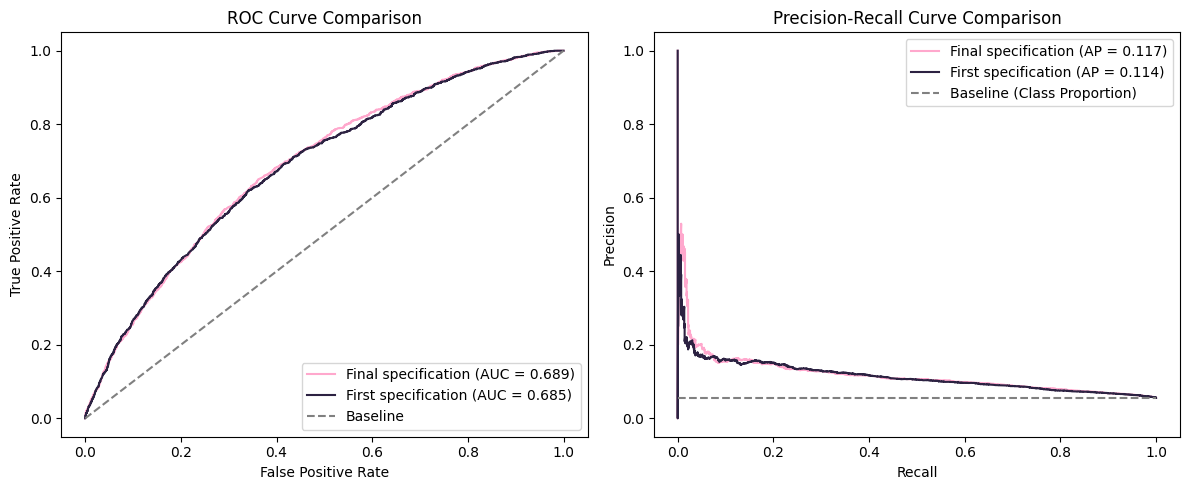

In [32]:
# Compare current model with the previous model
plt.figure(figsize=(12, 5))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'Final specification (AUC = {roc_auc:.3f})', color = '#FFA8CD')   #2C2242
plt.plot(fpr_1, tpr_1, label=f'First specification (AUC = {roc_auc_1:.3f})', color = '#2C2242') #FFA8CD
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'Final specification (AP = {ap:.3f})', color = '#FFA8CD')
plt.plot(recall_1, precision_1, label=f'First specification (AP = {ap_1:.3f})', color = '#2C2242')
plt.hlines(y_test.mean(), xmin=0, xmax=1, color='grey', linestyle='--', label='Baseline (Class Proportion)')
plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Feature importance on test data

In [33]:
model_object = final_model.named_steps['model']

In [34]:

# Create SHAP TreeExplainer for the tree-based model
explainer = shap.TreeExplainer(model_object)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_transformed)

# Wrap shap_values into an Explanation object
shap_values_with_names = shap.Explanation(
    values=shap_values,                   # SHAP values matrix
    base_values=explainer.expected_value, # Base values
    data=X_test_transformed,              # Transformed feature values
    feature_names=all_feature_names       # Feature names
)


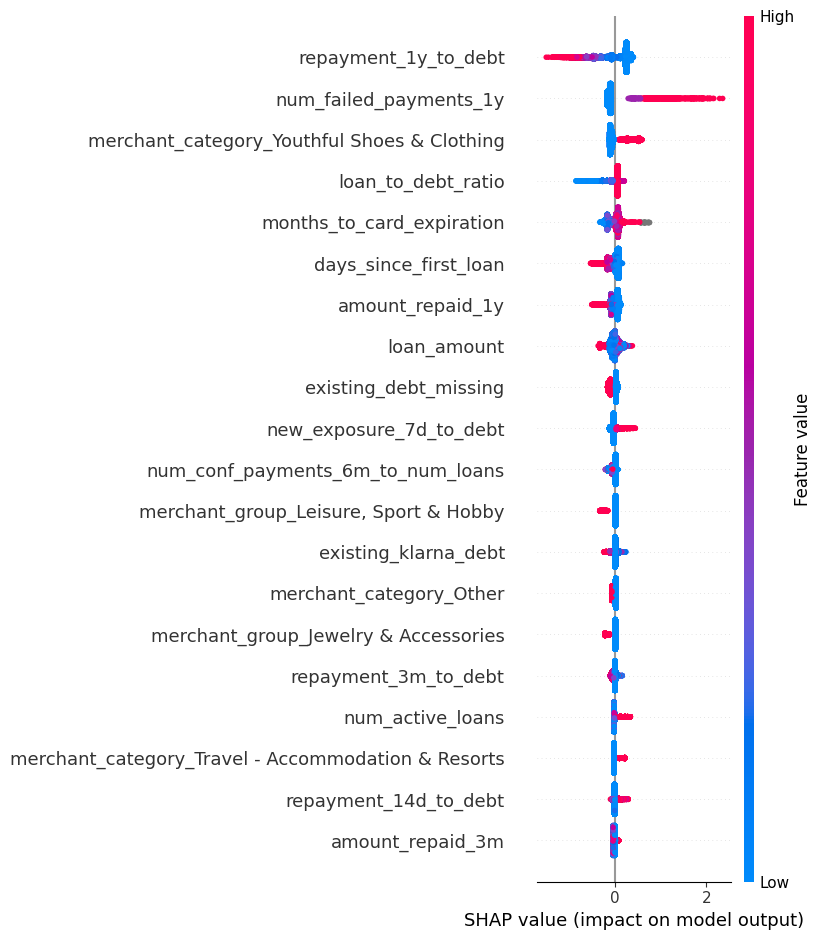

In [35]:
#  Density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output
shap.summary_plot(shap_values_with_names, X_test_transformed)

Zoom into an example

In [36]:
instance_idx = 55

feature_values = zip(all_feature_names, X_test_transformed[instance_idx, :])

# Display feature values in a readable format
print(f"Feature values for instance {instance_idx}:")
for feature_name, feature_value in feature_values:
    print(f"{feature_name}: {feature_value}")


Feature values for instance 55:
amount_repaid_14d: 9106.0
amount_repaid_1y: 17160.0
amount_repaid_3m: 17160.0
days_since_first_loan: 31.0
existing_debt_missing: 0.0
existing_klarna_debt: 37326.0
loan_amount: 19308.0
loan_to_debt_ratio: 0.34092594554507893
months_to_card_expiration: 10.0
new_exposure_14d: 19713.0
new_exposure_14d_to_debt: 0.34807712681428116
new_exposure_7d: 19713.0
new_exposure_7d_to_debt: 0.34807712681428116
num_active_loans: 2.0
num_conf_payments_6m_to_num_loans: 1.9999900000499997
num_confirmed_payments_3m: 4.0
num_failed_payments_1y: 0.0
num_failed_payments_3m: 0.0
num_failed_payments_6m: 0.0
repayment_14d_to_debt: 0.16078680651198926
repayment_1m_to_debt: 0.30299819896175445
repayment_1y_to_debt: 0.30299819896175445
repayment_3m_to_debt: 0.30299819896175445
merchant_category_Event - Broker & Agencies: 0.0
merchant_category_General Shoes & Clothing: 1.0
merchant_category_Other: 0.0
merchant_category_Travel - Accommodation & Resorts: 0.0
merchant_category_Youthful S

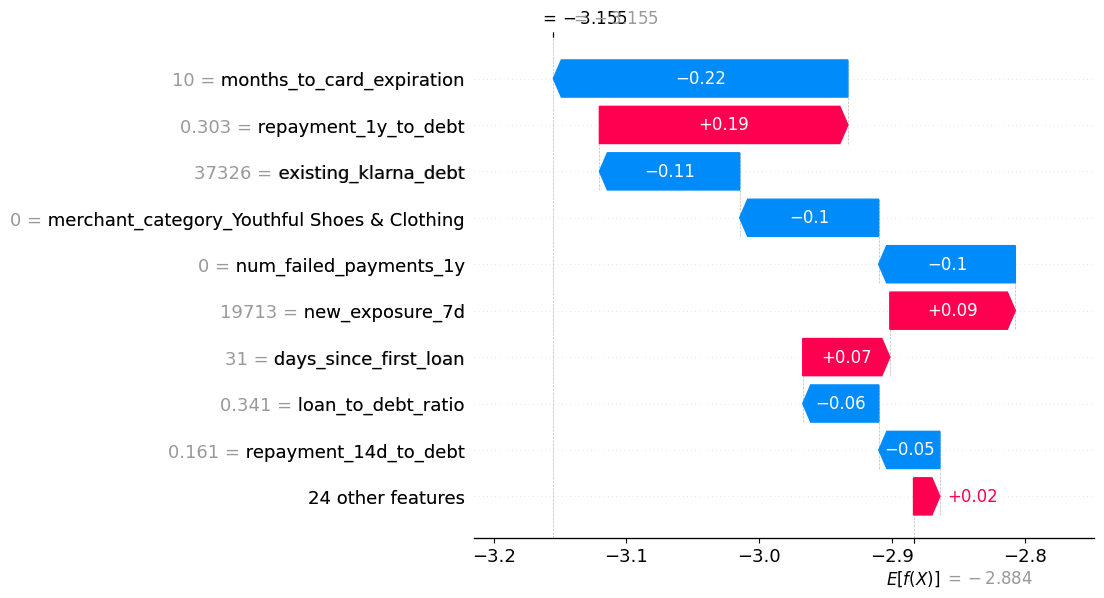

In [37]:
# Waterfall plot for the first prediction

# Extract SHAP values for the selected instance
shap_values_instance = shap.Explanation(
    values=shap_values[instance_idx], 
    base_values=explainer.expected_value, 
    data=X_test_transformed[instance_idx],
    feature_names=all_feature_names  
)

# Plot the waterfall chart
shap.waterfall_plot(shap_values_instance)